# Projeto 2 - arXiv Paper Abstract - Kaggle
## Preparação do ambiente
Faça o download e carregue o dataset arXiv Paper Abstracts (https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts).

# Exercícios


### Questão 1) 
Faça a leitura dos dados e implemente rotinas de pré-processamento:  
a) Implemente e justifique suas ações em relação ao tratamento dos rótulos (1,5 pontos)  


In [ ]:
!pip install spacy==3.3.1
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 6.7 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import pandas as pd
import re
import numpy as np
import warnings

warnings.filterwarnings("ignore")

import spacy

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
df = pd.read_csv('/content/arxiv_data.csv')
df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51774 entries, 0 to 51773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     51774 non-null  object
 1   summaries  51774 non-null  object
 2   terms      51774 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Todas as observações estão devidamente preenchidas, não teremos que lidar com valores nulos.  
A coluna 'terms' são os rótulos neste dataset.

In [ ]:
print(df['terms'][1])
print(type(df['terms'][1]))

['cs.CV', 'cs.AI', 'cs.LG']
<class 'str'>


In [ ]:
df['terms'].unique()

array(["['cs.CV', 'cs.LG']", "['cs.CV', 'cs.AI', 'cs.LG']",
       "['cs.CV', 'cs.AI']", ..., "['stat.ML', 'cs.LG', 'I.2.1; J.3']",
       "['cs.LG', 'cs.NE', 'q-bio.BM', 'stat.ML']",
       "['stat.ML', 'cs.CV', 'cs.LG', 'q-bio.QM']"], dtype=object)

Os dados, apesar de parecerem uma lista, são strings. Por todos os valores estarem dispostos dessa maneira, é possível tratá-los para então transformá-los em uma lista.
A principal caracteristica é que as informações relevantes estão entre aspas separados por uma virgula.

In [ ]:
regex_rule = "'\w{0,}.\w{0,}'"
df['terms'] = df['terms'].apply(lambda x : re.findall(regex_rule, x)) # retorna uma lista das strings entre aspas
df['terms'] = df['terms'].apply(lambda x : [re.sub("'", "", i) for i in x])  # Retira as aspas que foram usadas para localizar os rótulos.

In [ ]:
print(df['terms'][0][1])
df['terms'][0]

cs.LG


['cs.CV', 'cs.LG']

Os termos estão devidamente organizados em listas e podem ser devidamente acessados..

Agora, com tipo correto, os dados precisam ser adaptados já este é um problema de multi-rótulos. A abordagem mais comum é a de binarização dos rótulos, cada 'opção' de rotulo se torna uma coluna que terá o valor 1 caso a observação possua aquele rótulo e o valor 0 caso não possua aquele rótulo.

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(df['terms'])
y = mlb.transform(df['terms'])
print(y.shape)
y

(51774, 222)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

Os rótulos estão prontos para serem utilizados em um modelo.

b) Implemente e justifique suas ações em relação aos dados (titles e summaries) (1,5 pontos)

Após as verificações feitas anteriormente, sabemos que não há valores faltantes nas colunas 'titles' e 'summaries'. Tratando-se de textos, há apenas mais um problema a ser verificado: a ocorrência de valores duplicados.

In [ ]:
print(df["titles"].duplicated().sum())
print(df["summaries"].duplicated().sum())

12802
12795


Há 12802 títulos duplicados e 12795 sumários duplicados. Dados duplicados devem ser descartados já que não acrescentam nada ao modelo e podem, inclusive, enviesá-los.

In [ ]:
df = df.drop_duplicates(subset=['titles'], keep='last', ignore_index=True)
df = df.drop_duplicates(subset=['summaries'], keep='last', ignore_index=True)
print('"titles" duplicados: ', df["titles"].duplicated().sum())
print('"summaries" duplicados: ', df["summaries"].duplicated().sum())
print('Novo dataset:')
df

"titles" duplicados:  0
"summaries" duplicados:  0
Novo dataset:


,titles,summaries,terms
0,Quantifying and Mitigating Privacy Risks of Co...,Data is the key factor to drive the developmen...,"[cs.LG, cs.CR]"
1,Interest-oriented Universal User Representatio...,User representation is essential for providing...,[cs.LG]
2,"Learning Representations by Humans, for Humans",When machine predictors can achieve higher per...,"[cs.LG, cs.HC, stat.ML]"
3,Task Guided Compositional Representation Learn...,Zero-shot domain adaptation (ZDA) methods aim ...,[cs.CV]
4,Adversarial Representation Learning With Close...,Adversarial representation learning aims to le...,[cs.LG]
...,...,...,...
38961,Hierarchically-coupled hidden Markov models fo...,We address the problem of analyzing sets of no...,[stat.ML]
38962,Blinking Molecule Tracking,We discuss a method for tracking individual mo...,"[cs.CV, cs.DM]"
38963,Towards a Mathematical Foundation of Immunolog...,We attempt to set a mathematical foundation of...,"[stat.ML, cs.LG]"
38964,A Semi-Automatic Graph-Based Approach for Dete...,Diffusion Tensor Imaging (DTI) allows estimati...,[cs.CV]


In [ ]:
print(df['titles'][0], '\n')
df['summaries'][0]

Quantifying and Mitigating Privacy Risks of Contrastive Learning 



"Data is the key factor to drive the development of machine learning (ML)\nduring the past decade. However, high-quality data, in particular labeled data,\nis often hard and expensive to collect. To leverage large-scale unlabeled data,\nself-supervised learning, represented by contrastive learning, is introduced.\nThe objective of contrastive learning is to map different views derived from a\ntraining sample (e.g., through data augmentation) closer in their\nrepresentation space, while different views derived from different samples more\ndistant. In this way, a contrastive model learns to generate informative\nrepresentations for data samples, which are then used to perform downstream ML\ntasks. Recent research has shown that machine learning models are vulnerable to\nvarious privacy attacks. However, most of the current efforts concentrate on\nmodels trained with supervised learning. Meanwhile, data samples' informative\nrepresentations learned with contrastive learning may cause seve

Todas as quebras de linha vieram acompanhas de seu carácter de controle que necessita ser excluído.

In [ ]:
df['titles'] = df['titles'].apply(lambda x : re.sub("\n", " ", x)) # Substitui \n por espaços
df['titles'] = df['titles'].apply(lambda x : re.sub("  ", " ", x)) # Devido a inconsistencia nos textos, caso existam dois espaços seguidos, substitui por um espaço.
df['summaries'] = df['summaries'].apply(lambda x : re.sub("\n", " ", x))
df['summaries'] = df['summaries'].apply(lambda x : re.sub("  ", " ", x))

print(df['titles'][0], '\n')
df['summaries'][0]

Quantifying and Mitigating Privacy Risks of Contrastive Learning 



"Data is the key factor to drive the development of machine learning (ML) during the past decade. However, high-quality data, in particular labeled data, is often hard and expensive to collect. To leverage large-scale unlabeled data, self-supervised learning, represented by contrastive learning, is introduced. The objective of contrastive learning is to map different views derived from a training sample (e.g., through data augmentation) closer in their representation space, while different views derived from different samples more distant. In this way, a contrastive model learns to generate informative representations for data samples, which are then used to perform downstream ML tasks. Recent research has shown that machine learning models are vulnerable to various privacy attacks. However, most of the current efforts concentrate on models trained with supervised learning. Meanwhile, data samples' informative representations learned with contrastive learning may cause severe privacy r

Com os textos devidamente tratados podemos iniciar o processo de preparação dos dados para a entrada no nosso modelo. Os seguintes passos serão executados:

- Exclusão de stop words: stops words não acrescentam nada a um modelo de machine learning, stop words não possuem função semântica.
- Normalização: Todos os textos serão normalizados para letras minusculas.
- Tokenization: os textos serão dividos em tokens.
- Lemmatization: os tokens serão reduzidas aos seus lemas para que o ruído do texto seja diminuído mantendo somente a função semântica das palavras.

In [ ]:
X_summ_lemma = df['summaries'].apply(nlp) # Inicia o pré-processamento do texto com a biblioteca spacy
X_summ_lemma = X_summ_lemma.apply(lambda x: ' '.join(i.lemma_.lower() for i in x if ((not i.is_stop) & (not i.is_punct)))).to_list() # A função gera uma string com os lemas se não foram pontuação ou stop word.

X_title_lemma = df['titles'].apply(nlp)
X_title_lemma = X_title_lemma.apply(lambda x: ' '.join(i.lemma_.lower() for i in x if ((not i.is_stop) & (not i.is_punct)))).to_list()

In [ ]:
print(X_summ_lemma[0:5])

['data key factor drive development machine learning ml past decade high quality datum particular label datum hard expensive collect leverage large scale unlabeled datum self supervise learning represent contrastive learning introduce objective contrastive learning map different view derive training sample e.g. datum augmentation close representation space different view derive different sample distant way contrastive model learn generate informative representation datum sample perform downstream ml task recent research show machine learning model vulnerable privacy attack current effort concentrate model train supervised learning datum sample informative representation learn contrastive learning cause severe privacy risk   paper perform privacy analysis contrastive learning lens membership inference attribute inference experimental result contrastive model train image dataset vulnerable membership inference attack vulnerable attribute inference attack compare supervised model fact con

In [ ]:
print(X_title_lemma[0:5])

['quantify mitigating privacy risks contrastive learning', 'interest orient universal user representation contrastive learning', 'learn representation human human', 'task guided compositional representation learning zda', 'adversarial representation learning close form solver']


Com isso, as variáveis estão preparadas para a extração de caracteristicas.

Com a alteração no nº de linhas, os valores de y devem ser ajustados.

In [ ]:
# Repetição da binarização dos valores em 'terms' para adequar-se ao novo nº de linhas.

mlb = MultiLabelBinarizer()
mlb.fit(df['terms'])
y = mlb.transform(df['terms'])
print(y.shape)
y

(38966, 222)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

### Questão 2) 
Faça uma análise visual do dataset após o pré-processamento. Explore gráficos e/ou tabelas para mostrar a distribuição dos rótulos. (1,0 ponto)


In [ ]:
rotulos = [terms for i in df['terms'] for terms in i]

unique, counts = np.unique(rotulos, return_counts=True)
rotulos = pd.DataFrame({'Unique':unique, 'Counts':counts}).sort_values('Counts', ascending=False)
rotulos

,Unique,Counts
137,cs.CV,22251
151,cs.LG,22236
219,stat.ML,12422
130,cs.AI,5947
172,eess.IV,1762
...,...,...
90,86-08,1
91,90B18,1
92,90C10,1
93,90C26,1


Como podemos ver, há muitos rótulos presentes neste dataset que, além disso, estão desbalanceados. Por isso, o gráfico abaixo mostra o histograma com os 5 rótulos mais frequentes no dataset, apenas para se ter uma noção do comportamento dos dados.

Text(0, 0.5, 'Freq.')

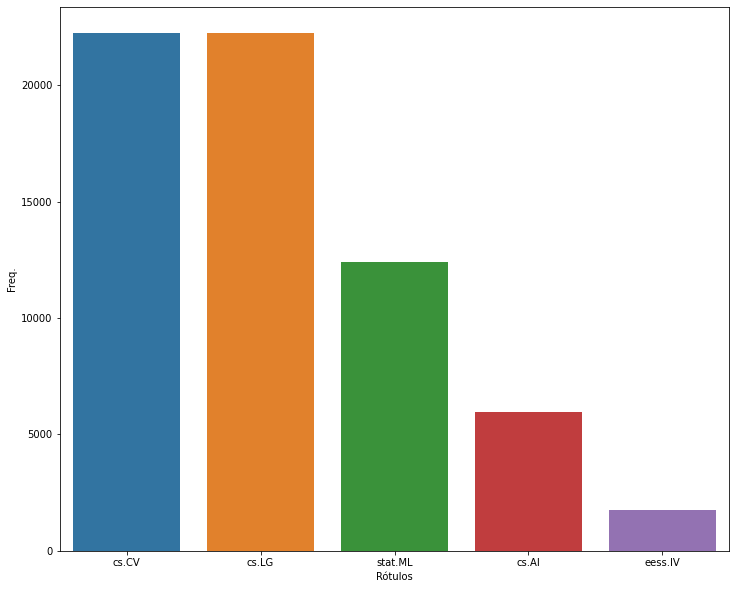

In [ ]:
plt.figure(figsize=(12,10))
sns.barplot(data=rotulos.head(5), x='Unique', y='Counts')
plt.xlabel('Rótulos')
plt.ylabel('Freq.')

Abaixo está a nuvem de palavras de todo o dataset, por termos muitas amostras com rótulo cs.CV e cs.LG, espera-se que as palavras mais frequentes sejam relacionadas a essa categoria de artigo

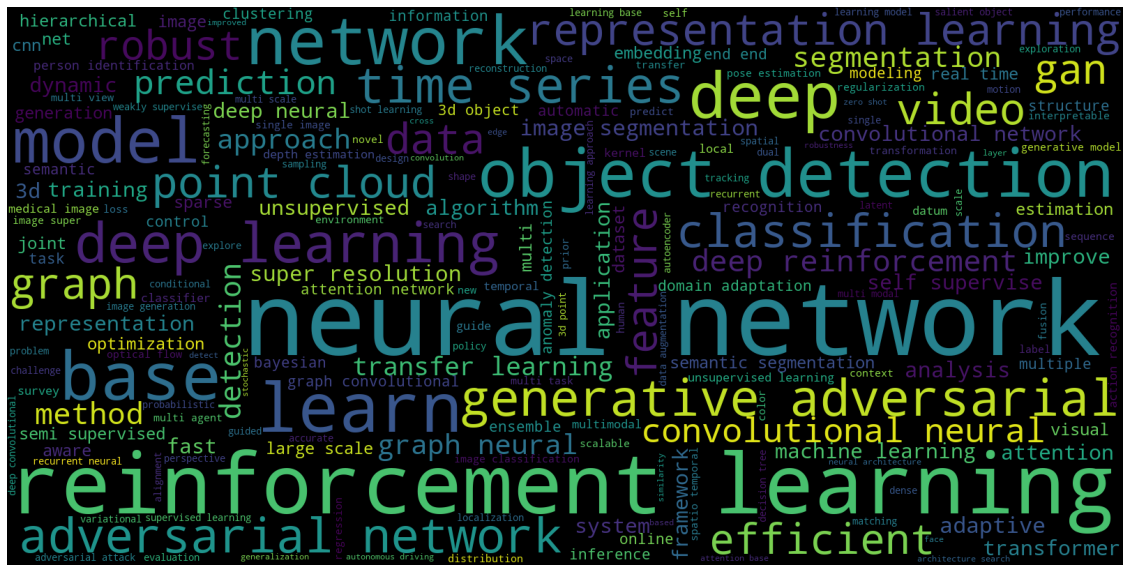

In [ ]:
# concatenar as palavras
all_summary = " ".join(s for s in X_title_lemma)
# lista de stopwords
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(all_summary)

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(20,12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

### Questão 3) 
Escolha uma metodologia para extração de características considerando somente o título dos artigos científicos. (1,0 ponto)


A ideia da extração de caracteristicas em textos é a de estruturar dados não estruturados para que possam ser utilizados em algum modelo de machine learning. Uma técnica comum para o tratamento de textos é a *Bag of words* que nos permite representar os textos com a ocorrência de cada palavra. Além disso, é possível aplicar a técnica TF-IDF (*Term Frequency - Inverse Document Frequency*) que mostra o quão importante é uma palavra é em um texto seguindo a seguinte fórmula:  


$$
   TFIDF = \frac{a}{b} * log{}{(\frac{\alpha}{\beta})}
$$

onde:  
a = Nº de vezes que uma palavra aparece no texto  
b = Nº de palavras no documento  
$\alpha$ = Total de documentos  
$\beta$  = Nº de documentos com o respectivo termo

No scikit learn, a função CountVectorizer combinada com a função tfidf_transformer realizam exatamente esse tipo de extração.

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_title_lemma)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_tittle = X_train_tfidf

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_summ_lemma)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_summ = X_train_tfidf

Ainda há um outro tipo de extração, chamada Word Embedding, neste tipo de extração as palavras são transformadas em vetores focando na semelhança entre os radicais e na relação dos termos.

In [ ]:
import gensim

sentences = [gensim.models.doc2vec.TaggedDocument(re.findall('[\w]{1,}', X_title_lemma[i]), [i]) for i in range(0, len(X_title_lemma))] # Os tokens precisam ser convertidos em um tipo especifico para entrada no modelo doc2vec
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=3, epochs=20)
model.build_vocab(sentences)

In [ ]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
X_title_lemma2 = []
for i in range(0, len(X_title_lemma)):
  X_title_lemma2.append(re.findall('[\w]{1,}', X_title_lemma[i])) # Separa os lemas para uma lista de palavras

In [ ]:
X_title_vec = []
for i in range(0, len(X_title_lemma2)):
  X_title_vec.append(model.infer_vector(X_title_lemma2[i])) # Transforma as palavras em vetores

In [ ]:
sentences = [gensim.models.doc2vec.TaggedDocument(re.findall('[\w]{1,}', X_summ_lemma[i]), [i]) for i in range(0, len(X_summ_lemma))] # Os tokens precisam ser convertidos em um tipo especifico para entrada no modelo doc2vec
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=3, epochs=20)
model.build_vocab(sentences)

X_summ_lemma2 = []
for i in range(0, len(X_summ_lemma)):
  X_summ_lemma2.append(re.findall('[\w]{1,}', X_summ_lemma[i])) # Separa os lemas para uma lista de palavras

X_summ_vec = []
for i in range(0, len(X_title_lemma2)):
  X_summ_vec.append(model.infer_vector(X_summ_lemma2[i])) # Transforma as palavras em vetores

### Questão 4) 
Implemente o processo de classificação multi rótulos. Implemente 3 classificadores diferentes e compare suas performances. Escolha duas métricas distintas de sua escolha. Justifique suas escolhas e interprete os resultados (2,0 pontos)


Métricas:   
- Hamming Loss: é a fração de rótulos classificados incorretamente sobre o total de rótulos. Quanto menor, melhor.  
- F1 score: melhor que acurácia para datasets desbalanceados, é a média harmonica entre precisão e recall. Utilizando a média 'micro' temos a média do f1 score considerando o valor total de valores verdadeiros positivos, falsos negativos e falsos positivos.


Classificadores:
- LinearSVC: A ideia do classificador é separar os dados com vetores e, uma vez que a Word Embedding transforma as palavras em vetores levando em conta suas relações, espera-se que classificadores baseados em algoritmos SVM tenham um bom desempenho.
- SGDClassifier: A mesma ideia acima, as frases foram transformadas em vetores então espera-se que modelos SVM tenham um bom desempenho.
- LogisticRegression: Uma das estrategias utilizadas para a classificação multi-rótulos é o One vs Rest que consiste na divisão da classificação em  diversos problemas de classificação binária diferentes. A regressão logistica consiste em probabilidades de uma observação pertencer a uma classe ou outra e, como a extração de caracteristicas TFIDF ilustra a presença e as relações de palavras importantes dentro de um texto, a natureza probabilista da regressão logistica pode trazer bons resultados.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier


from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss
from sklearn.model_selection import train_test_split

def predicoes (X1, X2, X1_vec, X2_vec, y_test, modelos):
  for i in modelos:
    print('-'*50)
    print(i,'\n')
    clf = OneVsRestClassifier(i)
    clf.fit(X1, y_train)
    y_pred = clf.predict(X2)
    print(f"F1_score TF-IDF = {f1_score(y_test, y_pred, average='micro')}")
    print(f"Hamming loss TF-IDF = {hamming_loss(y_test, y_pred)}", "\n")
    
    clf.fit(X1_vec, y_train)
    y_pred = clf.predict(X2_vec)
    print(f"F1_score Word Embedding = {f1_score(y_test, y_pred, average='micro')}")
    print(f"Hamming loss Word Embedding = {hamming_loss(y_test, y_pred)}")

seed = 23
# as variáveis são:
# X_tittle = X para titulos com todas as etapas de preparação
# X_summ = X para os sumários com todas as etapas de preparação
# X_title_vec e X_summ_vec são as variáveis com Word Embedding (ou seja, transformadas em vetores)

# Todas precisam ser fornecidas no mesmo train_test_split para que os mesmos indices sejam divididos.
splits = train_test_split(X_tittle, X_title_vec, X_summ, X_summ_vec, y, test_size=0.20, random_state=seed)

del X_tittle, X_summ, X_title_vec, X_summ_vec # Liberação de espaço na memória

(X_tittle_train, X_tittle_test) = splits[:2]
(X_title_vec_train, X_title_vec_test) = splits[2:4]
(X_summ_train, X_summ_test) = splits[4:6]
(X_summ_vec_train, X_summ_vec_test) = splits[6:8]
(y_train, y_test) = splits[8:]

svm = LinearSVC(random_state=seed)
sgdc = SGDClassifier(random_state=seed)
reg_log = LogisticRegression(random_state=seed)

modelos = [svm, sgdc, reg_log]

predicoes(X_tittle_train, X_tittle_test, X_title_vec_train, X_title_vec_test, y_test, modelos)

del X_tittle_train, X_tittle_test, X_title_vec_train, X_title_vec_test # Liberação de espaço na memória

--------------------------------------------------
LinearSVC(random_state=23) 

F1_score TF-IDF = 0.7030249176200526
Hamming loss TF-IDF = 0.0046356980537119105 

F1_score Word Embedding = 0.6037535141706558
Hamming loss Word Embedding = 0.006027967921732356
--------------------------------------------------
SGDClassifier(random_state=23) 

F1_score TF-IDF = 0.6872831032621269
Hamming loss TF-IDF = 0.004687135172123625 

F1_score Word Embedding = 0.5909765045663883
Hamming loss Word Embedding = 0.006056865179267027
--------------------------------------------------
LogisticRegression(random_state=23) 

F1_score TF-IDF = 0.6968932404443607
Hamming loss TF-IDF = 0.004651880517931326 

F1_score Word Embedding = 0.6049247709189638
Hamming loss Word Embedding = 0.006055131343814946


Analisando os resultados notamos uma melhor performance para o TF-IDF, provavelmente devido à complexidade do Word Embedding, onde cada frase tornou-se um vetor com 100 números, seria necessário um modelo mais robusto, capaz de lidar com situações mais complexas como uma rede neural, por exemplo.

Considerando apenas a técnica TF-IDF, quando comparamos os modelos percebemos resultados bem próximos com o LinearSVC tendo métricas levemente melhores. Isso acontece por quê a frequência das palavras permite uma boa divisão entre os rótulos.


### Questão 5) 
Replique os mesmos experimentos de extração de características e classificação considerando somente a coluna abstract. (2,0 pontos)


A extração de caracteristicas já foi realizada em passos anteiores sendo necessário realizar apenas a classificação

In [ ]:
predicoes(X_summ_train, X_summ_test, X_summ_vec_train, X_summ_vec_test, y_test, modelos)

--------------------------------------------------
LinearSVC(random_state=23) 

F1_score TF-IDF = 0.7313168572482478
Hamming loss TF-IDF = 0.004209752477650861 

F1_score Word Embedding = 0.5726446121106596
Hamming loss Word Embedding = 0.00766008502729057
--------------------------------------------------
SGDClassifier(random_state=23) 

F1_score TF-IDF = 0.7229543480723483
Hamming loss TF-IDF = 0.004240383570637612 

F1_score Word Embedding = 0.5726446121106596
Hamming loss Word Embedding = 0.00766008502729057
--------------------------------------------------
LogisticRegression(random_state=23) 

F1_score TF-IDF = 0.7247251723495435
Hamming loss TF-IDF = 0.004269280828172283 

F1_score Word Embedding = 0.5726446121106596
Hamming loss Word Embedding = 0.00766008502729057


Novamente a performance de classificações utilizando TF-IDF foram superiores, importante notar que apesar da performance das classificações utilizando TF-IDF serem melhores, as classificações utilizando Word Embedding foram significativamente piores. Talvez por que um vetor de 100 números não represente bem as características de um resumo (que possui muito mais informação que os títulos), porém, devido a falta de poder computacional na realização deste trabalho, este é o nosso limite.

### Questão 6)
Compare os resultados obtidos dos titles e abstracts. Qual atributo é mais discriminativo? (1,0 ponto)

Analisando o resultado vemos que o atributo mais descritivo é a coluna 'summaries'. Isso era esperado uma vez que essa coluna possui muito mais informação sobre os artigos quando em comparação com a coluna ‘tittles’, sendo assim, já era esperado que esta coluna apresentasse resultados melhores.